# A model for predicting the probability of a voter's opinion change based on tweeter posts

We will predict based on a dataset from kaggle about Twitter posts during the 2020 US election. 
Goal: By analyzing tweets, identify those users who are most likely to change their minds, cluster them to recommend what kind of messages will have a greater effect on them.

In [30]:
# System and utilities
import sys
import re
from datetime import datetime
from tqdm import tqdm

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Language detection
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

# PyTorch
import torch
from torch.utils.data import DataLoader, Dataset

# Transformers
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

# XGBoost
from xgboost import XGBClassifier

# Other
from scipy.stats import entropy
from scipy.sparse import hstack


Since our data consists of two datasets: one from the #Trump dataset and one from the #Biden dataset, to simplify the model and to select potentially only those users who are in America, we determine in which language the tweet is written and combine these two datasets 

In [ ]:
def safe_detect(text):
    try:
        if not isinstance(text, str) or len(text.strip()) < 5:
            return "unknown"
        return detect(text)
    except LangDetectException:
        return "unknown"

df_trump = pd.read_csv('hashtag_donaldtrump.csv', lineterminator='\n')
df_biden= pd.read_csv('hashtag_joebiden.csv', lineterminator='\n')
tqdm.pandas(desc="Detecting language")
# Trump
df_trump['lang'] = df_trump['tweet'].progress_apply(safe_detect)
df_trump_en = df_trump[df_trump['lang'] == 'en'].reset_index(drop=True)
df_trump_en.to_csv('hashtag_donaldtrump_en.csv', index=False)
df_trump = pd.read_csv('hashtag_donaldtrump_en.csv')
#Biden 
df_biden['lang'] = df_biden['tweet'].progress_apply(safe_detect)
df_biden_en = df_biden[df_biden['lang'] == 'en'].reset_index(drop=True)
df_biden_en.to_csv('hashtag_donaldtrump_en.csv', index=False)
df_biden = pd.read_csv('hashtag_donaldtrump_en.csv')

#Add a labeled column with candidate name
df_trump['candidate'] = 'Trump'  
df_biden['candidate'] = 'Biden'  # Добавляем колонку с меткой

combined_df = pd.concat([df_trump, df_biden], axis=0)




# Sentiment Analysis of Tweets Using RoBERTa
This block performs automatic sentiment annotation of tweets using the pre-trained model *cardiffnlp/twitter-roberta-base-sentiment.* The choice of this model is motivated by several factors:

1. **Domain-specific training:** The model has been fine-tuned specifically on English-language tweets, making it well-suited for handling the informal language, abbreviations, hashtags, and mentions typical of Twitter.

2. **Modern architecture:** Based on the RoBERTa transformer, this model improves classification accuracy compared to earlier models such as BERT.

3. **Three-class sentiment output:** The model classifies each tweet into one of three categories — negative (0), neutral (1), or positive (2) — which aligns well with our goal of detecting political leanings and emotional intensity.

This sentiment labeling serves as a crucial preprocessing step in identifying users who may be emotionally volatile or politically ambivalent, which helps inform the target audience detection system.

In [ ]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

df = combined_df
tweets = df['tweet'].dropna().tolist()

class TweetDataset(Dataset):    
    def __init__(self, texts, tokenizer, max_len=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
=
batch_size = 128
dataset = TweetDataset(tweets, tokenizer)
dataloader = DataLoader(dataset, batch_size=batch_size)

labels = []
scores = []

with torch.no_grad():
    for batch in tqdm(dataloader):
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask = batch['attention_mask'].squeeze(1).to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        
        label = torch.argmax(probs, dim=1).cpu().numpy()
        score = torch.max(probs, dim=1).values.cpu().numpy()
        
        labels.extend(label)
        scores.extend(score)

df = df.loc[:len(labels)-1] 
df['roberta_label'] = labels
df['roberta_score'] = scores

# 
df.to_csv("annotated_tweets_all.csv", index=False)


After running the sentiment analysis pipeline using the cardiffnlp/twitter-roberta-base-sentiment model, each tweet in the dataset has been enriched with two new attributes:

**roberta_label:** the predicted sentiment class for each tweet:

0 = Negative

1 = Neutral

2 = Positive

**roberta_score:** the confidence score of the model, representing the probability assigned to the predicted sentiment class (ranging from 0 to 1).


In [3]:
# Open the files received after processing through RobErta. 
robert = pd.read_csv('annotated_tweets_all.csv')
filtered_users = robert.groupby('user_id').filter(lambda x: len(x) >= 2)
razmetka = pd.read_excel('Разметка.xlsx')

In [4]:
#Position classification
def classify_position(label, candidate):
    if label == 0 and candidate == 'Biden':
        return 'Against Biden'
    elif label == 2 and candidate == 'Trump':
        return 'Against Biden'
    elif label == 2 and candidate == 'Biden':
        return 'Pro Biden'
    elif label == 0 and candidate == 'Trump':
        return 'Against Trump'
    elif label == 2 and candidate == 'Trump':
        return 'Pro Trump'
    elif label == 0 and candidate == 'Biden':
        return 'Pro Trump'
    elif label == 1:
        return 'Neutral'
    else:
        return 'Neutral'
        
        # SEIZ
def get_seiz_state(label, score):
    if label == 1 and score < 0.5:
        return 'S'
    elif label == 1 and 0.5 <= score < 0.8:
        return 'E'
    elif label in [0, 2] and score > 0.8:
        return 'I'
    elif label in [0, 2] and score < 0.6:
        return 'Z'
    else:
        return 'E'

#Change of position
def count_position_changes(positions):
    return sum(1 for i in range(1, len(positions)) if positions[i] != positions[i - 1])

def avg_time_between_changes(times, positions):
    changes = [i for i in range(1, len(positions)) if positions[i] != positions[i - 1]]
    if len(changes) < 2:
        return np.nan
    timestamps = [datetime.strptime(str(times[i]), "%Y-%m-%d %H:%M:%S") for i in changes]
    deltas = [(timestamps[i] - timestamps[i - 1]).total_seconds() for i in range(1, len(timestamps))]
    return np.mean(deltas) if deltas else np.nan

def seiz_state_variability(states):
    return len(set(states)) / len(states) if states else 0

def roberta_low_conf_ratio(scores):
    return sum(score < 0.5 for score in scores) / len(scores)

def stance_entropy(positions):
    dist = pd.Series(positions).value_counts(normalize=True)
    return entropy(dist)

def stance_reversals(positions):
    return sum(positions[i] == positions[i-2] and positions[i] != positions[i-1]
               for i in range(2, len(positions)))

# Feature engineering
def advanced_user_features(user_df):
    positions = list(user_df['position'])
    times = list(user_df['created_at'])
    seiz_states = list(user_df['seiz_state'])
    scores = list(user_df['roberta_score'])

    n_tweets = len(positions)
    n_changes = count_position_changes(positions)
    change_freq = n_changes / (n_tweets - 1) if n_tweets > 1 else 0
    time_change_avg = avg_time_between_changes(times, positions)
    time_weight = 1 / (1 + np.log1p(time_change_avg)) if not np.isnan(time_change_avg) else 0
    score_confidence = 1 - np.mean(scores)
    score_std = np.std(scores)
    seiz_var = seiz_state_variability(seiz_states)
    seiz_dist = pd.Series(seiz_states).value_counts(normalize=True)
    seiz_ent = entropy(seiz_dist)
    share_neutral = positions.count("Neutral") / n_tweets
    unique_positions = len(set(positions))
    first_time = pd.to_datetime(user_df["created_at"].min())
    last_time = pd.to_datetime(user_df["created_at"].max())
    days_span = (last_time - first_time).days + 1
    tweet_density = n_tweets / days_span if days_span > 0 else n_tweets

    # Новые признаки
    low_conf_ratio = roberta_low_conf_ratio(scores)
    stance_ent = stance_entropy(positions)
    reversals = stance_reversals(positions)

    return pd.Series({
        "user_id": user_df["user_id"].iloc[0],
        "change_freq": change_freq,
        "time_weight": time_weight,
        "score_confidence": score_confidence,
        "score_std": score_std,
        "seiz_var": seiz_var,
        "seiz_entropy": seiz_ent,
        "num_tweets": n_tweets,
        "share_neutral": share_neutral,
        "unique_positions": unique_positions,
        "days_span": days_span,
        "tweet_density": tweet_density,
        "low_conf_ratio": low_conf_ratio,
        "stance_entropy": stance_ent,
        "stance_reversals": reversals
    })

In [ ]:
filtered_users['position'] = filtered_users.apply(lambda row: classify_position(row['roberta_label'], row['candidate']), axis=1)
filtered_users['seiz_state'] = filtered_users.apply(lambda row: get_seiz_state(row['roberta_label'], row['roberta_score']), axis=1)

user_features_df = filtered_users.groupby('user_id').apply(advanced_user_features).reset_index(drop=True)
labeled_df = user_features_df.merge(razmetka, on="user_id", how="inner")

# 🎯 Моделирование
features = [
    "change_freq", "score_std", "seiz_entropy", "share_neutral", "num_tweets",
    "time_weight", "unique_positions", "days_span", "tweet_density",
    "low_conf_ratio", "stance_entropy", "stance_reversals"
]
X = labeled_df[features]
y = labeled_df["changed_opinion"]

# 🧹 Обработка пропусков
X = X.fillna(X.mean())

# 🔀 Разделение
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# 🚀 Обучение моделей
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
logreg = LogisticRegression(max_iter=1000)
voting = VotingClassifier(estimators=[('xgb', xgb), ('lr', logreg)], voting='soft')

xgb.fit(X_train, y_train)
logreg.fit(X_train, y_train)
voting.fit(X_train, y_train)

# 📈 Предсказания
xgb_pred = xgb.predict(X_test)
xgb_proba = xgb.predict_proba(X_test)[:, 1]

logreg_pred = logreg.predict(X_test)
logreg_proba = logreg.predict_proba(X_test)[:, 1]

voting_pred = voting.predict(X_test)
voting_proba = voting.predict_proba(X_test)[:, 1]

# 📊 Оценка моделей
xgb_report = classification_report(y_test, xgb_pred, output_dict=True)
logreg_report = classification_report(y_test, logreg_pred, output_dict=True)
voting_report = classification_report(y_test, voting_pred, output_dict=True)

xgb_roc = roc_auc_score(y_test, xgb_proba)
logreg_roc = roc_auc_score(y_test, logreg_proba)
voting_roc = roc_auc_score(y_test, voting_proba)

# ✅ Результаты
results = {
    "XGBoost ROC AUC": xgb_roc,
    "LogReg ROC AUC": logreg_roc,
    "Voting ROC AUC": voting_roc,
    "XGBoost F1 (1)": xgb_report["1"]["f1-score"],
    "LogReg F1 (1)": logreg_report["1"]["f1-score"],
    "Voting F1 (1)": voting_report["1"]["f1-score"]
}
print("📊 Final Evaluation Results:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")
# ======= Apply the best model (Logistic Regression) to all users =======

# Подготовка полного набора пользователей
X_all = user_features_df[features].copy()
X_all = X_all.fillna(X_all.mean())

# Предсказания
user_features_df["predicted_label"] = logreg.predict(X_all)
user_features_df["probability_1"] = logreg.predict_proba(X_all)[:, 1]

# Сохранение результата
user_features_df.to_csv("model_predictions_for_all_users.csv", index=False)

print("✅ File 'model_predictions_for_all_users.csv' saved successfully.")

C:\Users\Игорь\AppData\Local\Temp\ipykernel_3420\2062270337.py:61: RuntimeWarning: invalid value encountered in log1p
  time_weight = 1 / (1 + np.log1p(time_change_avg)) if not np.isnan(time_change_avg) else 0
C:\Users\Игорь\AppData\Local\Temp\ipykernel_3420\2062270337.py:61: RuntimeWarning: invalid value encountered in log1p
  time_weight = 1 / (1 + np.log1p(time_change_avg)) if not np.isnan(time_change_avg) else 0
C:\Users\Игорь\AppData\Local\Temp\ipykernel_3420\2062270337.py:61: RuntimeWarning: invalid value encountered in log1p
  time_weight = 1 / (1 + np.log1p(time_change_avg)) if not np.isnan(time_change_avg) else 0
C:\Users\Игорь\AppData\Local\Temp\ipykernel_3420\2062270337.py:61: RuntimeWarning: invalid value encountered in log1p
  time_weight = 1 / (1 + np.log1p(time_change_avg)) if not np.isnan(time_change_avg) else 0
C:\Users\Игорь\AppData\Local\Temp\ipykernel_3420\2062270337.py:61: RuntimeWarning: invalid value encountered in log1p
  time_weight = 1 / (1 + np.log1p(time_cha

Fitting 3 folds for each of 36 candidates, totalling 108 fits


c:\Users\Игорь\.conda\envs\tfenv\lib\site-packages\xgboost\training.py:183: UserWarning: [16:06:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Игорь\.conda\envs\tfenv\lib\site-packages\xgboost\training.py:183: UserWarning: [16:06:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model evaluation: {'best_params': {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 300, 'scale_pos_weight': 1.5, 'subsample': 0.8}, 'classification_report': {'0': {'precision': 0.7777777777777778, 'recall': 0.875, 'f1-score': 0.8235294117647058, 'support': 376.0}, '1': {'precision': 0.6299212598425197, 'recall': 0.45977011494252873, 'f1-score': 0.53156146179402, 'support': 174.0}, 'accuracy': 0.7436363636363637, 'macro avg': {'precision': 0.7038495188101488, 'recall': 0.6673850574712643, 'f1-score': 0.677545436779363, 'support': 550.0}, 'weighted avg': {'precision': 0.7310013521037143, 'recall': 0.7436363636363637, 'f1-score': 0.7311613694103434, 'support': 550.0}}, 'roc_auc': np.float64(0.7604395940327707)}


In [27]:
# ✅ Проверка наличия GPU
device = 0 if torch.cuda.is_available() else -1
print(f"✅ Using device: {'GPU' if device == 0 else 'CPU'}")

# 📥 Загрузка данных
tweets_df = pd.read_csv("annotated_tweets_all.csv")
pred_df = pd.read_csv("model_predictions_for_all_users.csv")

# 📊 Отбор пользователей с probability > 0.5
change_users = pred_df[pred_df["probability_1"] > 0.5]["user_id"]
filtered_tweets = tweets_df[tweets_df["user_id"].isin(change_users)].copy()

# 🧹 Очистка текста
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

filtered_tweets["clean_text"] = filtered_tweets["tweet"].apply(clean_text)

# 🤖 Загрузка zero-shot классификатора (GPU если доступен)
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=device)

# 🏷️ Тематические метки
labels = ["Economy", "Public Health / COVID-19", "Corruption / Integrity",
          "Social Justice", "Foreign Policy / Security", "Other"]

# 🧠 Классификация твитов
tqdm.pandas()
filtered_tweets["topic"] = filtered_tweets["clean_text"].progress_apply(
    lambda x: classifier(x, labels)["labels"][0]
)

# 📊 Распределение тем
topic_counts = filtered_tweets["topic"].value_counts()
print("📈 Topic Distribution:\n", topic_counts)

# 💾 Сохранение
filtered_tweets.to_csv("classified_change_tweets_ml.csv", index=False)
topic_counts.to_csv("topic_distribution_ml.csv")

✅ Using device: GPU


Device set to use cuda:0
100%|██████████| 302008/302008 [6:52:28<00:00, 12.20it/s]  


📈 Topic Distribution:
 topic
Other                        226632
Economy                       22515
Corruption / Integrity        20699
Social Justice                15391
Foreign Policy / Security     12137
Public Health / COVID-19       4634
Name: count, dtype: int64


# Разметка

In [ ]:
all_chat_data = []

for user_id, group in sheet1_df.groupby("user_id"):
    user_chat = {
        "user_id": user_id,
        "text_broken": [
            f"[{row['created_at']}] {row['tweet']} ({row['position']})"
            for _, row in group.sort_values("created_at").iterrows()
        ]
    }
    all_chat_data.append(user_chat)

In [21]:
robert = pd.read_csv('annotated_tweets_all.csv')
sampled_robert = filtered_users.sample(n=20000, random_state = 42) 
filtered_users = sampled_robert.groupby('user_id').filter(lambda x: len(x) >= 2)
filtered_users = filtered_users.sort_values(by='user_id')


In [ ]:
all_chat_data = []

for user_id, group in sheet1_df.groupby("user_id"):
    user_chat = {
        "user_id": user_id,
        "text_broken": [
            f"[{row['created_at']}] {row['tweet']} ({row['position']})"
            for _, row in group.sort_values("created_at").iterrows()
        ]
    }
    all_chat_data.append(user_chat)

In [26]:
import pandas as pd
from openai import OpenAI
import httpx
import time
from tqdm import tqdm

# === Load Excel ===
df = filtered_users.copy()

# === Initialize DeepSeek client ===
client = OpenAI(
    api_key="sk-6e8863a33f9842548d252ecdd4b2ff64",
    base_url="https://api.deepseek.com",
    http_client=httpx.Client(verify=False)
)

# === Build prompt ===
def build_change_detection_prompt(user_chat):
    chat_text = "\n".join(f"[{i}] {msg}" for i, msg in enumerate(user_chat["text_broken"]))
    return f"""
Below are one user's tweets, sorted by time.
Each message contains the date, the text of the tweet, and the user's political position
(e.g., Pro Trump, Against Biden, Neutral).

{chat_text}

Question: Did the user change his/her political position in these tweets?
Answer: Write 1 if he/she did and 0 if he/she did not.
"""

# === Query DeepSeek for a single user ===
def query_opinion_change_label(user_chat, client):
    prompt = build_change_detection_prompt(user_chat)
    try:
        response = client.chat.completions.create(
            model="deepseek-chat",
            messages=[
                {"role": "system", "content": "'Youre an assistant to analyze the political opinions of Twitter users. Answer strictly 0 or 1."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.2
        )
        result = response.choices[0].message.content.strip()
        return int(result) if result in {"0", "1"} else None
    except Exception as e:
        print(f"❌ Error for user_id={user_chat['user_id']}: {e}")
        return None

# === Group tweets and build input for each user ===
all_chat_data = []
for user_id, group in df.groupby("user_id"):
    user_chat = {
        "user_id": user_id,
        "text_broken": [
            f"[{row['created_at']}] {row['tweet']} ({row['position']})"
            for _, row in group.sort_values("created_at").iterrows()
        ]
    }
    all_chat_data.append(user_chat)

# === Loop with progress bar and neutral-only pre-check ===
results = []
neutral_skipped = 0

for user_chat in tqdm(all_chat_data, desc="🔎 Annotating users"):
    # Auto-classify as '1' if all tweets are Neutral
    all_neutral = all("(Neutral)" in msg for msg in user_chat["text_broken"])
    
    if all_neutral:
        label = 1
        neutral_skipped += 1
    else:
        label = query_opinion_change_label(user_chat, client)
        time.sleep(1.5)  # ⏱ Respect rate limits for API calls

    results.append({
        "user_id": user_chat["user_id"],
        "changed_opinion": label
    })

# === Save the result ===
df_results = pd.DataFrame(results)
df_results.to_excel("deepseek_user_opinion_labels.xlsx", index=False)
print("✅ Saved to deepseek_user_opinion_labels.csv")
print(f"ℹ️ Skipped {neutral_skipped} users with only Neutral tweets.")


🔎 Annotating users: 100%|██████████| 2717/2717 [3:52:05<00:00,  5.13s/it]  


PermissionError: [Errno 13] Permission denied: 'deepseek_user_opinion_labels.xlsx'

In [27]:
df_results.to_excel("deepseek_user_opinion_labels.xlsx", index=False)

In [7]:
razmetka = pd.read_excel('razmetka.xlsx')

In [8]:
razmetka

,user_id,created_at,position,tweet,roberta_label,roberta_score,seiz_state
0,16241878,2020-10-15 01:02:05,Against Trump,#Trump pleading for suburban women to 'like' h...,0,0.683815,E
1,16241878,2020-10-15 15:51:59,Neutral,#Trump is all about 'ratings'. \n#Biden is all...,1,0.568030,E
2,16241878,2020-10-15 15:51:59,Neutral,#Trump is all about 'ratings'. \n#Biden is all...,1,0.568030,E
3,16241878,2020-10-15 17:17:22,Against Trump,...just as soon as #Mexico pays for his (faile...,0,0.604223,E
4,16241878,2020-10-19 20:24:51,Against Trump,Shocking. \n\n#Trump's unprepared to tell the ...,0,0.867361,I
...,...,...,...,...,...,...,...
671,1323598586211388928,2020-11-07 22:35:32,Neutral,"The 'modus operandi' of a #Democrat, a #Social...",1,0.600624,E
672,1323598586211388928,2020-11-08 17:11:08,Against Trump,The #Biden idiots celebrating his 'win' have n...,0,0.770750,E
673,1323598586211388928,2020-11-08 17:11:08,Against Biden,The #Biden idiots celebrating his 'win' have n...,0,0.770750,E
674,1325125942390320896,2020-11-07 17:34:29,Against Trump,THE ELECTION IS NOT OVER ! #Trump,0,0.505962,Z


In [15]:
robert_100_users.to_excel('razmetka.xlsx')

In [4]:

# Подразумевается, что DataFrame `robert` уже загружен, и его нужно обработать

# Удаление пользователей с одним твитом
tweet_counts = robert['user_id'].value_counts()
robert = robert[robert['user_id'].isin(tweet_counts[tweet_counts > 1].index)]

# Классификация позиции
def classify_position(label, candidate):
    if label == 0 and candidate == 'Biden':
        return 'Against Biden'
    elif label == 2 and candidate == 'Trump':
        return 'Against Biden'
    elif label == 2 and candidate == 'Biden':
        return 'Pro Biden'
    elif label == 0 and candidate == 'Trump':
        return 'Against Trump'
    elif label == 2 and candidate == 'Trump':
        return 'Pro Trump'
    elif label == 0 and candidate == 'Biden':
        return 'Pro Trump'
    elif label == 1:
        return 'Neutral'
    else:
        return 'Neutral'

robert['position'] = robert.apply(lambda row: classify_position(row['roberta_label'], row['candidate']), axis=1)

# Группировка и формирование истории
user_position_changes = robert.groupby('user_id')[['tweet_id', 'created_at', 'position', 'tweet', 'roberta_label', 'roberta_score']].apply(lambda x: x.reset_index(drop=True)).reset_index()

# Эмоциональное состояние
def get_seiz_state(label, score):
    if label == 1 and score < 0.5:
        return 'S'
    elif label == 1 and 0.5 <= score < 0.8:
        return 'E'
    elif label in [0, 2] and score > 0.8:
        return 'I'
    elif label in [0, 2] and score < 0.6:
        return 'Z'
    else:
        return 'E'

user_position_changes['seiz_state'] = user_position_changes.apply(
    lambda row: get_seiz_state(row['roberta_label'], row['roberta_score']), axis=1
)

# Преобразование даты
user_position_changes['created_at'] = pd.to_datetime(user_position_changes['created_at'])

# Сортировка по времени
user_position_changes = user_position_changes.sort_values(by=['user_id', 'created_at'])

# Метрики и итоговый скор
def count_position_changes(positions):
    return sum(pos1 != pos2 for pos1, pos2 in zip(positions[:-1], positions[1:]))

def avg_time_between_changes(dates, positions):
    changes = []
    last_pos = positions[0]
    last_time = dates[0]
    for i in range(1, len(positions)):
        if positions[i] != last_pos:
            delta = (dates[i] - last_time).total_seconds() / 3600
            changes.append(delta)
            last_pos = positions[i]
            last_time = dates[i]
    return np.mean(changes) if changes else np.nan

def seiz_state_variability(states):
    return len(set(states)) / len(states) if len(states) > 0 else 0

def compute_change_score(user_df):
    positions = list(user_df['position'])
    times = list(user_df['created_at'])
    seiz_states = list(user_df['seiz_state'])
    scores = list(user_df['roberta_score'])

    n_tweets = len(positions)
    n_changes = count_position_changes(positions)
    change_freq = n_changes / (n_tweets - 1) if n_tweets > 1 else 0

    time_change_avg = avg_time_between_changes(times, positions)
    time_weight = 1 / (1 + np.log1p(time_change_avg)) if not np.isnan(time_change_avg) else 0

    score_confidence = 1 - np.mean(scores)
    seiz_var = seiz_state_variability(seiz_states)

    score = (0.4 * change_freq +
             0.25 * time_weight +
             0.2 * score_confidence +
             0.15 * seiz_var)

    return min(1.0, max(0.0, score))

# Расчёт change_score для каждого пользователя
user_scores = user_position_changes.groupby('user_id').apply(compute_change_score).reset_index()
user_scores.columns = ['user_id', 'change_score']


Разметить самому 50-100 вариантов, по сути передаю роазметку . а потом настраиваю модельку. 2 вариант Ембендинг считать на оставшихся понять 

user_scores

In [5]:
user_scores

,user_id,change_score
0,2.654000e+03,0.341894
1,2.737000e+03,0.412558
2,6.210000e+03,0.197024
3,1.211100e+04,0.465694
4,1.341300e+04,0.374089
...,...,...
137451,1.325543e+18,0.186856
137452,1.325545e+18,0.168426
137453,1.325550e+18,0.635055
137454,1.325564e+18,0.828521


In [17]:
user_scores[user_scores['user_id']==16241878]

,user_id,change_score
2348,16241878.0,0.401896


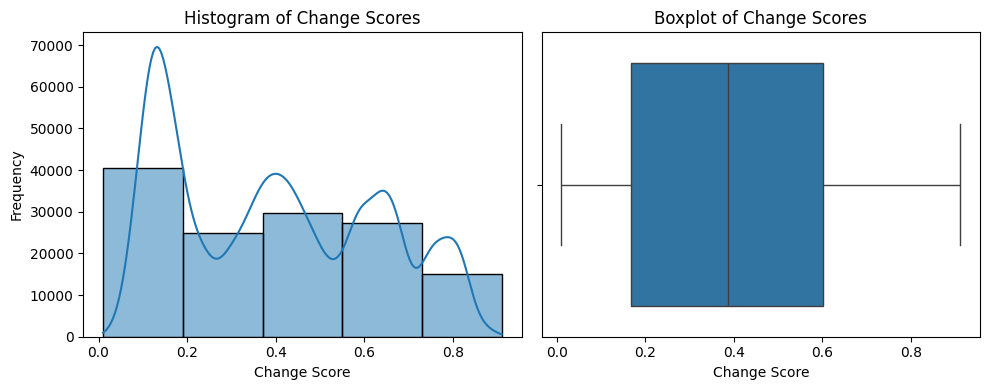

In [5]:


# Построение гистограммы и boxplot
plt.figure(figsize=(10, 4))

# Гистограмма
plt.subplot(1, 2, 1)
sns.histplot(user_scores['change_score'], bins=5, kde=True)
plt.title('Histogram of Change Scores')
plt.xlabel('Change Score')
plt.ylabel('Frequency')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=user_scores['change_score'])
plt.title('Boxplot of Change Scores')
plt.xlabel('Change Score')

plt.tight_layout()
plt.show()


In [7]:
user_scores.to_excel('users.xlsx')

In [58]:
dataset

,user_id,n_tweets,change_freq,time_weight,score_conf,seiz_var,change_score,predicted_change_score
0,2.654000e+03,22.0,0.428571,0.252345,0.349770,0.181818,0.329774,0.334692
1,2.737000e+03,9.0,0.625000,0.197608,0.336506,0.333333,0.416362,0.415791
2,6.210000e+03,2.0,0.000000,0.233799,0.235118,1.000000,0.197024,0.197836
3,1.211100e+04,6.0,0.600000,0.226303,0.374224,0.666667,0.467467,0.481365
4,1.341300e+04,5.0,0.500000,0.202995,0.337048,0.400000,0.374089,0.389888
...,...,...,...,...,...,...,...,...
137451,1.325543e+18,2.0,0.000000,0.883390,0.184282,1.000000,0.186856,0.186187
137452,1.325545e+18,2.0,0.000000,0.816972,0.467128,0.500000,0.168426,0.167840
137453,1.325550e+18,5.0,0.750000,0.817417,0.404747,0.400000,0.635055,0.613976
137454,1.325564e+18,2.0,1.000000,0.000000,0.517604,0.500000,0.828521,0.828135


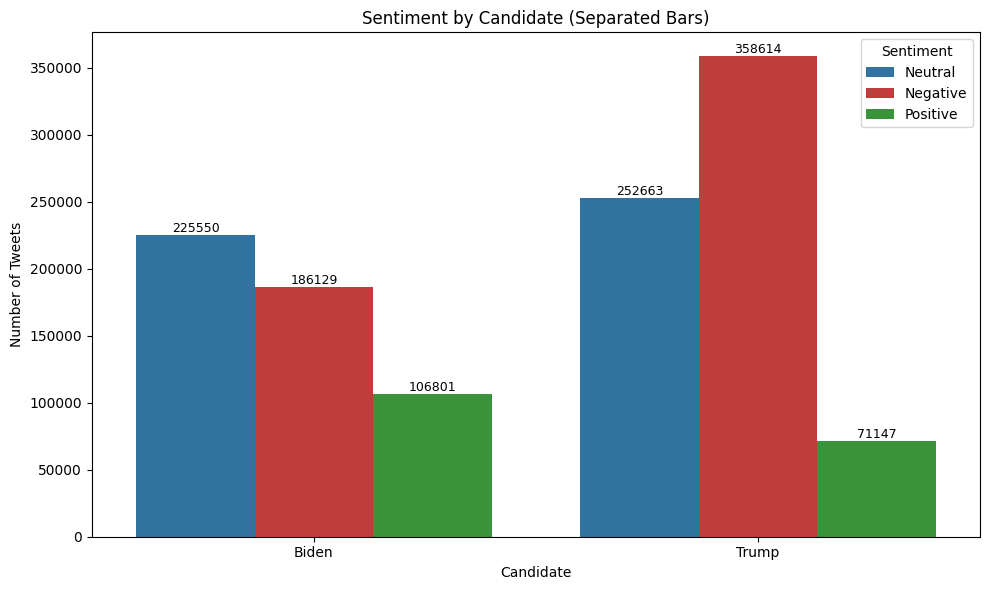

In [4]:


# Данные
# Преобразование меток
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
df_robert_plot["sentiment"] = df_robert_plot["roberta_label"].map(label_map)
df_robert_plot = df_robert_plot.drop(columns=["roberta_label"])

# Палитра
palette = {"Negative": "#d62728", "Neutral": "#1f77b4", "Positive": "#2ca02c"}

# Построение графика
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_robert_plot,
    x="candidate",
    y="count",
    hue="sentiment",
    palette=palette
)

# Добавляем подписи
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=9)

# Настройки графика
plt.title("Sentiment by Candidate (Separated Bars)")
plt.xlabel("Candidate")
plt.ylabel("Number of Tweets")
plt.legend(title="Sentiment")
plt.grid(False)
plt.tight_layout()
plt.show()


In [48]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

# Настройка
bert_model_name = "bert-base-uncased"
batch_size = 32  # Можешь увеличить, если хватает видеопамяти

# Загрузка модели и токенизатора
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
model = AutoModel.from_pretrained(bert_model_name)

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Подготовка данных
texts = all_tweets['tweet'].tolist()
all_embeddings = []

# Обработка батчами
for i in tqdm(range(0, len(texts), batch_size), desc="BERT batching on GPU"):
    batch_texts = texts[i:i+batch_size]
    
    # Токенизация батча
    inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding='max_length', max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Получение CLS-эмбеддингов
    batch_embeddings = outputs.last_hidden_state[:, 0, :]  # (batch_size, 768)
    all_embeddings.append(batch_embeddings.cpu())

# Объединение всех батчей
all_embeddings = torch.cat(all_embeddings, dim=0).numpy()

# Преобразование в DataFrame
embedding_all_tweets = pd.DataFrame(all_embeddings)
embedding_all_tweets.columns = [f"bert_dim_{i}" for i in range(embedding_all_tweets.shape[1])]

# Объединение с исходным all_tweets
all_tweets_bert = pd.concat([all_tweets.reset_index(drop=True), embedding_all_tweets], axis=1)

BERT batching on GPU: 100%|██████████| 37529/37529 [35:27<00:00, 17.64it/s]


In [ ]:
all_tweets_bert

In [ ]:
#label: метка тональности (0 = отрицательная, 1 = нейтральная, 2 = положительная)

def get_seiz_state(label, score):
    if label == 1 and score < 0.5:
        return 'S'  # нейтральный и неуверенный
    elif label == 1 and 0.5 <= score < 0.8:
        return 'E'  # нейтральный, но вовлечённый
    elif label in [0, 2] and score > 0.8:
        return 'I'  # активный сторонник
    elif label in [0, 2] and score < 0.6:
        return 'Z'  # негатив без вовлечённости / скептик
    else:
        return 'E'  # всё остальное — пограничное
all_tweets['seiz_state'] = all_tweets.apply(
    lambda row: get_seiz_state(row['roberta_label'], row['roberta_score']), axis=1
)
# Приводим created_at к дате, если нужно
all_tweets['created_at'] = pd.to_datetime(all_tweets['created_at'])

# Сортируем по времени
all_tweets = all_tweets.sort_values(by=['user_id', 'created_at'])

# Берём последнее состояние каждого пользователя
user_final_state = all_tweets.groupby('user_id').tail(1)[['user_id', 'seiz_state']]
all_tweets_R_S = all_tweets.merge(user_final_state, on='user_id', suffixes=('', '_final'))


In [14]:
user_final_state

,user_id,seiz_state
9983,5.310000e+02,E
1087595,1.081000e+03,E
1158658,1.889000e+03,E
594461,2.654000e+03,E
478041,2.737000e+03,Z
...,...,...
651253,1.325567e+18,E
651399,1.325569e+18,E
1178358,1.325575e+18,E
651382,1.325579e+18,E


In [53]:
all_tweets_R_S[all_tweets_R_S['seiz_state']!=all_tweets_R_S['seiz_state_final']]['user_id'].nunique()

79827

In [26]:
final_df=  all_tweets.merge(all_tweets_bert, on='user_id', suffixes=('', '_final'))

In [30]:
n_users = user_candidate_counts['user_id'].nunique()         # должно быть 193168
n_candidates = user_candidate_counts['candidate'].nunique()  # должно быть 2 (Trump, Biden)
print(n_users, n_candidates)


193168 2


Посмотреть
Твиты, в начале про одного каддидиата положительно про всех нейтрельно , ЕСть каждый твит последовательность твитов 
user tweet (тональность) уверености больше всего то сомвневающихся

In [54]:
from sklearn.preprocessing import LabelEncoder
user_candidate_counts = all_tweets.groupby(['user_id', 'candidate']).size().reset_index(name='tweet_count')
user_candidate_counts
user_encoder = LabelEncoder()
candidate_encoder = LabelEncoder()
user_ids = user_candidate_counts['user_id'].values
cand_values = user_candidate_counts['candidate'].values
user_idx = user_encoder.fit_transform(user_ids)         # кодируем user_id в диапазон 0..N-1
candidate_idx = candidate_encoder.fit_transform(cand_values)  # кодируем кандидатов (Trump/Biden) в 0/1
import numpy as np
from scipy.sparse import coo_matrix

rows = user_idx               # индекс пользователя (row index)
cols = candidate_idx          # индекс кандидата (col index)
data = user_candidate_counts['tweet_count'].values  # вес (число твитов)

# Создаем COO-матрицу; shape = (число_пользователей, число_кандидатов)
user_item_coo = coo_matrix((data, (rows, cols)), 
                            shape=(len(user_encoder.classes_), len(candidate_encoder.classes_)))
# Конвертируем в CSR для эффективности в ALS
user_item_csr = user_item_coo.tocsr()
from implicit.cpu.als import AlternatingLeastSquares
als_model = AlternatingLeastSquares(factors=64, regularization=0.1, iterations=15, random_state=42)
als_model.fit(user_item_csr)
user_factors = als_model.user_factors  # NumPy array
print(user_factors.shape)              # ожидаем (193168, 64)
user_index = np.arange(user_factors.shape[0])  # [0, 1, 2, ..., 193167]
original_user_ids = user_encoder.inverse_transform(user_index)
import pandas as pd
df_embeddings = pd.DataFrame(user_factors)
df_embeddings.insert(0, 'user_id', original_user_ids)  # вставляем колонку user_id в начало


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

(331238, 64)


In [55]:
df_embeddings.to_csv("df_embeddingsASL.csv")

KeyboardInterrupt: 

In [56]:
df_embeddings

,user_id,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
0,5.310000e+02,0.001383,-0.004209,0.000534,-0.002708,-0.017541,0.004084,0.002112,-0.000748,-0.001911,...,0.007203,-0.002114,-0.002138,0.003316,0.009034,-0.002431,0.002545,-0.003317,-0.000732,0.015465
1,1.081000e+03,0.096956,0.110131,-0.015926,0.034943,-0.149482,0.016943,-0.064265,0.057470,0.009215,...,-0.090050,-0.023476,0.064542,0.109030,0.007739,-0.028826,0.101001,0.039775,-0.053586,0.031014
2,1.889000e+03,0.096955,0.110136,-0.015927,0.034943,-0.149475,0.016945,-0.064264,0.057470,0.009215,...,-0.090049,-0.023477,0.064540,0.109030,0.007741,-0.028826,0.101000,0.039776,-0.053586,0.031015
3,2.654000e+03,0.100336,0.110093,-0.020070,0.039580,-0.169979,0.015850,-0.069703,0.059367,0.005646,...,-0.079898,-0.029622,0.067852,0.114713,0.024798,-0.031687,0.107340,0.054744,-0.053317,0.040231
4,2.737000e+03,0.001307,-0.004371,0.000229,-0.002487,-0.017189,0.003709,0.001905,-0.000803,-0.002077,...,0.007661,-0.002270,-0.002038,0.002998,0.009522,-0.002380,0.002453,-0.002221,-0.000587,0.015021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331233,1.325567e+18,0.001385,-0.004217,0.000534,-0.002704,-0.017548,0.004085,0.002110,-0.000752,-0.001910,...,0.007207,-0.002114,-0.002138,0.003316,0.009034,-0.002432,0.002545,-0.003318,-0.000733,0.015464
331234,1.325569e+18,0.001386,-0.004211,0.000534,-0.002710,-0.017549,0.004088,0.002114,-0.000749,-0.001913,...,0.007210,-0.002114,-0.002137,0.003317,0.009038,-0.002432,0.002546,-0.003317,-0.000733,0.015467
331235,1.325575e+18,0.096955,0.110134,-0.015926,0.034942,-0.149466,0.016945,-0.064264,0.057470,0.009215,...,-0.090051,-0.023477,0.064543,0.109030,0.007743,-0.028826,0.101001,0.039773,-0.053586,0.031000
331236,1.325579e+18,0.001387,-0.004221,0.000533,-0.002705,-0.017541,0.004086,0.002111,-0.000750,-0.001910,...,0.007204,-0.002114,-0.002135,0.003317,0.009033,-0.002432,0.002545,-0.003317,-0.000732,0.015466


In [51]:
import umap.umap_ as umap

# Выполняем UMAP на всех пользователях
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(embeddings)

# Создание датафрейма с результатами UMAP
umap_df = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"])
umap_df["user_id"] = df_embeddings["user_id"]

# Визуализация
plt.figure(figsize=(10, 7))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", s=10, alpha=0.3)
plt.title("UMAP Projection of ALS Embeddings (All Users)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(False)
plt.tight_layout()
plt.show()

NameError: name 'embeddings' is not defined

In [59]:
features_df.to_csv("feature.csv")

KeyboardInterrupt: 

In [65]:
features_df[['user_id','score_mean','score_std','neutral_ratio','seiz_state_mode','seiz_state_encoded','target','swayability_prob']].to_csv('feature.csv')

Последовательность ли твита, скользящий или нет по три класса на кандидата , 0 1 2 и есть среднее

Примеры точно не меняющиеся ( топили байдена и гасили трампа) - 0. Точно изменилисьб( поносят байдена и трампа) - 1 или всегда Нейтрально писали (2). Делая гарантированную разметку, во времени свапнулся (сколько таких из всего народа ),  1 11 0000, 1010101. Выдаеит вероятность смены . Сортирую задача ранга топ 100 

ROBERT классификацию

РАстягиваю разметку на сложных чуваков



Применяю ранкид


In [ ]:
Разумно ли ? Сосал?